In [27]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def compute_mean_SD(ests):
    if len(ests.shape) == 1:
        ests = ests.reshape(1, -1)
    ests = ests.mean(axis=0) # reps-dim
    SE = np.std(ests) / np.sqrt(ests.shape[0])
    mean_est = ests.mean()
    return mean_est, SE, mean_est - 2*SE, mean_est + 2*SE

class DDMModel():
    """
    Simulates samples from a DDM model.
    
    Parameters
    ----------
    delta : drift parameter
    alpha : volatility parameter
    b : boundary. This is a function b(t), defaults to a line
    """
    
    def __init__(self, delta, alpha=1, b=None):
        
        self.delta = delta
        self.alpha = alpha
        if b is None:
            b = lambda x: np.minimum(0.1 + np.log(1+x), 1)
            #b = lambda x: np.ones(x.shape)

        self.b = b
        
    def sample_many(self, reps=100, eps=1e-2, max_tau=100, plot=False):
        
        # Simulate brownian motion
        num_zs = int(max_tau/eps)
        Bt = np.cumsum(
            np.sqrt(eps) * np.random.randn(num_zs, reps), axis=0
        )
        Bt = np.concatenate([np.zeros(reps).reshape(1,-1), Bt], axis=0)
        
        # Add drift
        t = eps * np.arange(0, num_zs+1, 1)
        Zt = self.delta * t.reshape(-1, 1) + self.alpha * Bt
        
        # Compare to boundary
        bt = self.b(t)
        flags = np.abs(Zt) > bt.reshape(-1, 1)
        tau_inds = np.argmax(flags, axis=0)
        taus = t[tau_inds]

        # Plotting
        if plot:
            fig, ax = plt.subplots()
            ax.plot(t, bt, color='black', label='b(t)')
            ax.plot(t, -1*bt, color='black')
            ax.plot(t, Zt[:, 0], color='red', label='Z1')
            ax.plot(t, Zt[:, 1], color='blue', label='Z2')
            plt.legend()
            plt.show()
        
        # Create decisions: upper boundary = 1
        xflags = Zt[tau_inds, np.arange(reps)] > bt[tau_inds]
        xflags = xflags.astype(np.float32)
        
        # Create NaNs
        taus[tau_inds == 0] = np.nan
        xflags[tau_inds == 0] = np.nan
        return xflags, taus

In [28]:
0.1 + np.log(1 + 0.04)

0.13922071315328133

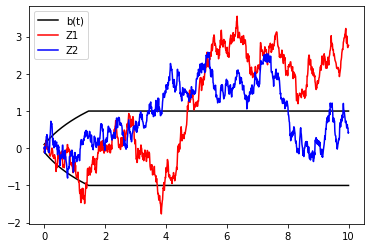

0.0


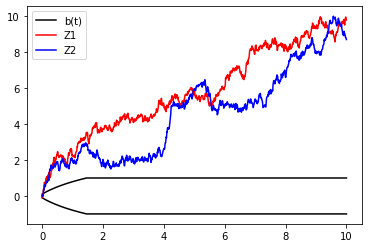

In [29]:
np.random.seed(111)


ddmmodel = DDMModel(delta=0.1)
reps = 50000
choices, taus = ddmmodel.sample_many(reps=reps, max_tau=10, plot=True)
print(np.isnan(taus).mean())

ddmmodel2 = DDMModel(delta=1)
choices2, taus2 = ddmmodel2.sample_many(reps=reps, max_tau=10, plot=True)

In [30]:
compute_mean_SD(taus)

(0.04468120000000001,
 0.00044199851507804866,
 0.043797202969843914,
 0.04556519703015611)

In [31]:
compute_mean_SD(taus2)

(0.04353380000000001,
 0.00037363924466147824,
 0.04278652151067706,
 0.044281078489322966)

<AxesSubplot:ylabel='Count'>

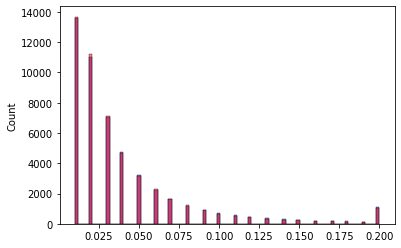

In [34]:
import seaborn as sns
sns.histplot(np.minimum(taus, 0.2), color='blue', alpha=0.5)
sns.histplot(np.minimum(taus2, 0.2), color='red', alpha=0.5)
